In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# print the table name
inspector = inspect(engine)

# Get table information
print(inspector.get_table_names())

for table_name in inspector.get_table_names():
    print(f'Table Name {table_name}')
    columns = inspector.get_columns(table_name)
    for column in columns:
        print(column["name"], column["type"], column['primary_key'])



['measurement', 'station']
Table Name measurement
id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0
Table Name station
id INTEGER 1
station TEXT 0
name TEXT 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
m_tbl = Base.classes.measurement
s_tbl = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
last_date = session.query(m_tbl.date).order_by(m_tbl.date.desc()).first()
last_date.date


'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Convert the string to a date object
last_date_str = last_date.date
last_datetime = dt.datetime.fromisoformat(last_date_str)
print(type(last_datetime))

# Calculate the date one year from the last date in data set.
#Substract 365 days to go back by an year
query_datetime = last_datetime - dt.timedelta(days=365)
print(type(query_datetime))

print(f"Last date: {last_datetime}")
print(f"Query date (one year ago): {query_datetime}")

# Perform a query to retrieve the data and precipitation scores
results = session.query(m_tbl.date,m_tbl.prcp).filter( m_tbl.date >= query_datetime.date()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcps_df = pd.DataFrame(results,columns=['date','precipitation'])

# Important to drop the Nan values else the days with Nan value is not displayed in the graph
prcps_df = prcps_df.dropna()  
prcps_df.set_index('date', inplace=True)

print(prcps_df.head())
print(prcps_df.info())


<class 'datetime.datetime'>
<class 'datetime.datetime'>
Last date: 2017-08-23 00:00:00
Query date (one year ago): 2016-08-23 00:00:00
            precipitation
date                     
2016-08-23           0.00
2016-08-24           0.08
2016-08-25           0.08
2016-08-26           0.00
2016-08-27           0.00
<class 'pandas.core.frame.DataFrame'>
Index: 2021 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  2021 non-null   float64
dtypes: float64(1)
memory usage: 31.6+ KB
None


In [27]:

# Sort the dataframe by date
sorted_prcps_df = prcps_df.sort_index()
sorted_prcps_df.info()
print(sorted_prcps_df.to_string(index=True))


<class 'pandas.core.frame.DataFrame'>
Index: 2021 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  2021 non-null   float64
dtypes: float64(1)
memory usage: 31.6+ KB
            precipitation
date                     
2016-08-23           0.00
2016-08-23           0.02
2016-08-23           0.05
2016-08-23           0.70
2016-08-23           0.15
2016-08-23           1.79
2016-08-24           1.22
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           1.45
2016-08-25           0.21
2016-08-25           0.08
2016-08-25           0.00
2016-08-25           0.06
2016-08-25           0.00
2016-08-25           0.08
2016-08-25           0.11
2016-08-26           0.04
2016-08-26           0.02
2016-08-26           0.00
2016-08-26           0.00
2016-08-26           0.01
2016-08-26           0.03
2016-08-

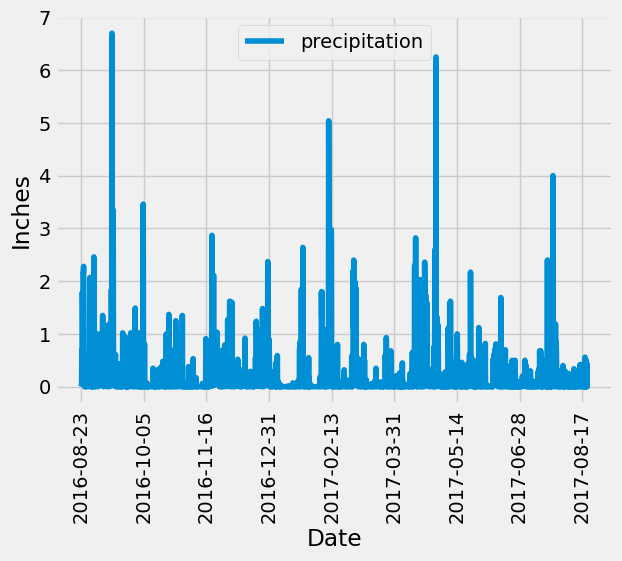

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')
sorted_prcps_df.plot(xlabel='Date',ylabel='Inches')
plt.xticks(rotation=90)
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_prcps_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_cnt = session.query(func.count(s_tbl.id)).all()
station_cnt

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [m_tbl.station,
       func.count(m_tbl.station)]
station_grp_query = session.query(*sel).\
    group_by(m_tbl.station).\
    order_by(func.count(m_tbl.station).desc()).all()
station_grp_query



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# which station id has the greatest number of observations?
most_active_st_name = station_grp_query[0]
most_active_st_name.station
print(most_active_st_name.station)


USC00519281


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(m_tbl.tobs),
      func.max(m_tbl.tobs),
      func.avg(m_tbl.tobs)]

temp_query = session.query(*sel).\
    filter(m_tbl.station == most_active_st_name.station).all()
temp_query

[(54.0, 85.0, 71.66378066378067)]

Last date: 2017-08-18
Query date (one year ago): 2016-08-18


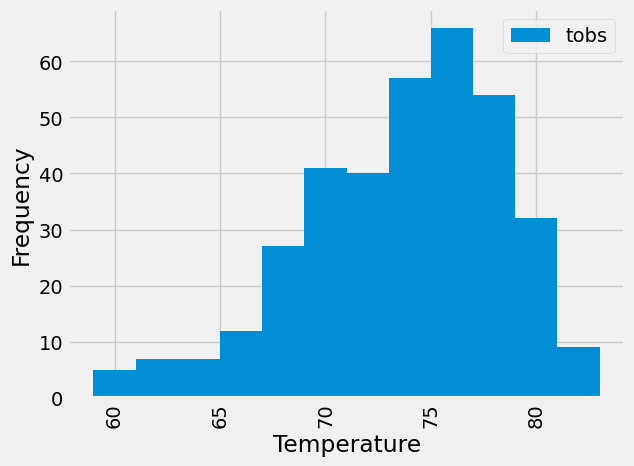

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_date = session.query(m_tbl.date).\
filter(m_tbl.station == most_active_st_name.station).\
order_by(m_tbl.date.desc()).\
first()

last_date.date

# Convert the string to a date object
last_date_str = last_date.date
last_date_obj = dt.date.fromisoformat(last_date_str)

#Substract 365 days to go back by an year
query_date = last_date_obj - dt.timedelta(days=365)

print(f"Last date: {last_date_obj}")
print(f"Query date (one year ago): {query_date}")

# Perform a query to retrieve the TOBS data for the last 1 year
results = session.query(m_tbl.tobs).\
filter(m_tbl.station == most_active_st_name.station, m_tbl.date >= query_date)
tobs_df = pd.DataFrame(results,columns=['tobs'])

plt.style.use('fivethirtyeight')
tobs_df.plot(xlabel='Temperature',ylabel='Frequency',kind='hist',bins=12)
plt.xticks(rotation=90)
plt.show()


# Close Session

In [20]:
# Close Session
session.close()